In [1]:
import pandas as pd
import numpy as np

import requests
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18,9

def parser(time_data):
    return pd.datetime.strptime('2017-'+time_data,'%Y-%d-%m %H:%M:%S')
data = pd.read_csv('../data/namenode_1130-1212.csv',header=0,index_col=0, parse_dates=[0], date_parser=parser)

data = data.rename(columns={'cpu process':'top_cpu','memory process':'top_mem'})
data['top_cpu'] = data['top_cpu'].str.partition('/')[0]
data['top_mem'] = data['top_mem'].str.partition('/')[0]


/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
buff_data = data['buff'].copy()
buff_data = buff_data.to_frame()

# 归一化

In [4]:
scaler = preprocessing.MinMaxScaler()
buff_data['norm'] = scaler.fit_transform(buff_data['buff'].values.reshape(-1,1))
norm_data = buff_data['norm']

# 平稳性检测

In [6]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]

# 检测是否为白噪声

In [11]:
from statsmodels.stats.diagnostic import acorr_ljungbox
def test_stochastic(ts):
    p_value = acorr_ljungbox(ts, lags=1)[1]
    return p_value

test_stochastic(data['usr'])

# 寻找最佳差分阶数

In [21]:
def best_diff(df,col='norm',maxdiff=8):
    pvalues = {}
    for i in range(maxdiff+1):
        temp = df.copy()
        if i == 0:
            temp['diff'] = temp[col]
        else:
            temp['diff'] = temp[col].diff(i)
            temp = temp.drop(temp.iloc[:i].index)
        p_value = test_stationarity(temp['diff'])
        pvalues[i] = p_value
    for i in range(maxdiff + 1):
        if pvalues[i] < 0.01:
            break
    return i,pvalues

In [25]:
diff_i,pvalues = best_diff(buff_data)
print('best diff is :%d' % diff_i)
pvalues

best diff is :1


{0: 0.96434338709230871,
 1: 0.0,
 2: 0.0,
 3: 0.0,
 4: 2.3167438381518285e-30,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0}

In [31]:
buff_data['diff1'] = buff_data['buff'].diff(1)
buff_data['diff2'] = buff_data['buff'].diff(2)

# 寻找最佳p,q

In [ ]:
import statsmodels.tsa.stattools as stools
def best_pq(ts,max_ar=7,max_ma=7):
    order = stools.arma_order_select_ic(ts,max_ar=max_ar,max_ma=max_ma,ic=['aic', 'bic', 'hqic'])
    return order.bic_min_order
order_diff1 = best_pq(buff_data['diff1'][1:])

/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimizat

/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/zhiyedan/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimizat

# 拟合model

In [ ]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(buff_data['diff1'][1:], order=(1, 4))
result_arma = model.fit(disp=-1, method='css')

# revserse transform

In [ ]:
def predict_recover(ts,scaler):
    ts = scaler.inverse_transform(ts)
    return ts

In [32]:
buff_data

,buff,norm,diff1,diff2
date/time,,,,
2017-11-30 09:37:39,218750976.0,0.000000,NaN,NaN
2017-11-30 09:38:40,218750976.0,0.000000,0.0,NaN
2017-11-30 09:39:39,218750976.0,0.000000,0.0,0.0
2017-11-30 09:40:39,218750976.0,0.000000,0.0,0.0
2017-11-30 09:41:39,218750976.0,0.000000,0.0,0.0
2017-11-30 09:42:39,218750976.0,0.000000,0.0,0.0
2017-11-30 09:43:40,218750976.0,0.000000,0.0,0.0
2017-11-30 09:44:40,218750976.0,0.000000,0.0,0.0
2017-11-30 09:45:40,218750976.0,0.000000,0.0,0.0


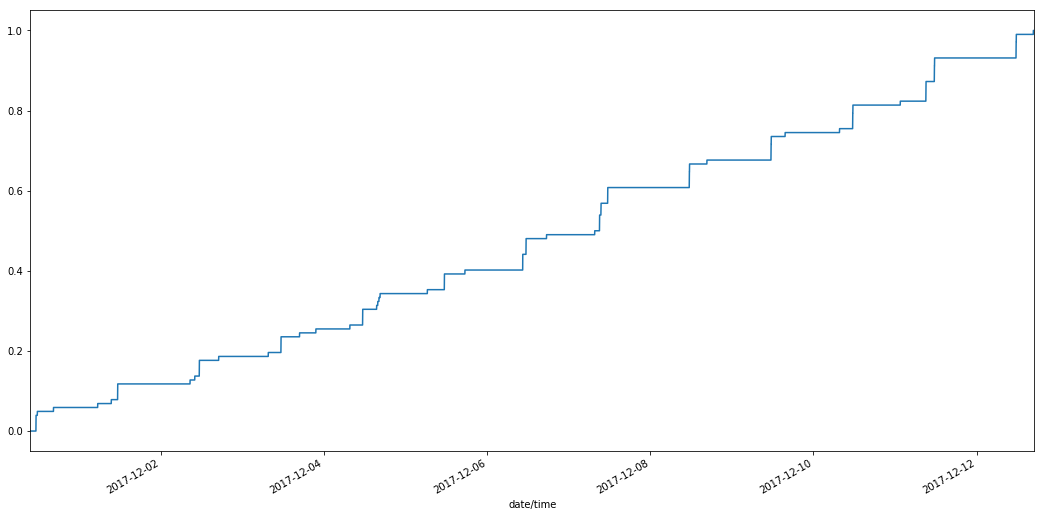

In [5]:
norm_data.plot()
plt.show()